In [37]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [ ]:
# Step 2: Load the cleaned data
df = pd.read_csv("cleaned_target.csv")

In [24]:
df

,X.locale,Address.AddressLine1,Address.City,Address.CountryName,Address.County,Address.FormattedAddress,Address.IntersectionDescription,Address.Latitude,Address.Longitude,Address.PostalCode,...,Summary.Sat,ThruTime.Sat,BeginTime.Sun,Is24Hours.Sun,IsOpen.Sun,Summary.Sun,ThruTime.Sun,AllCapability,StoreOpenYear,YearsSinceRemodel
0,en-US,400 Oxford Exchange Blvd,Oxford,United States,Calhoun,"400 Oxford Exchange Blvd, Oxford, AL 36203-3459",SEC I-20 & Golden Creek Rd,33.608825,-85.783182,36203-3459,...,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Café', 'Mobile Kiosk', 'Star...",2006,NaN
1,en-US,2640 Enterprise Dr,Opelika,United States,Lee,"2640 Enterprise Dr, Opelika, AL 36801-1511",NWC I-85 & Hwy 280,32.618108,-85.410636,36801-1511,...,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Cafe-Pizza', 'Fresh Grocery'...",2005,NaN
2,en-US,1129 S Park St,Carrollton,United States,Carroll,"1129 S Park St, Carrollton, GA 30117-4429",NWC US 27 & Hwy 166 Bypass,33.558920,-85.076473,30117-4429,...,8:00 a.m.-10:00 p.m.,22:00:00,8:00:00,False,True,8:00 a.m.-9:00 p.m.,21:00:00,Unknown,1997,NaN
3,en-US,555 Bullsboro Dr,Newnan,United States,Coweta,"555 Bullsboro Dr, Newnan, GA 30265-1045",SWC I-85 & Rte 34,33.392907,-84.758875,30265-1045,...,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Café', 'Fresh Grocery', 'Mob...",1999,12.0
4,en-US,1591 Bradley Park Dr,Columbus,United States,Muscogee,"1591 Bradley Park Dr, Columbus, GA 31904-3071",NEC Bradley Pk & JR Allen Pkwy,32.534649,-84.971073,31904-3071,...,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Café', 'Mobile Kiosk', 'Phot...",1999,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,en-US,22832 US Highway 281 N,San Antonio,United States,Bexar,"22832 US Highway 281 N, San Antonio, TX 78258-...",NEC Hwy 281 & Stone Oak Pkwy,29.653311,-98.445034,78258-7430,...,8:00 a.m.-12:00 a.m.,0:00:00,8:00:00,False,True,8:00 a.m.-11:00 p.m.,23:00:00,"['Bakery', 'CVS pharmacy', 'Cafe-Pizza', 'Deli...",2007,NaN
1825,en-US,135 Creekside Way,New Braunfels,United States,Comal,"135 Creekside Way, New Braunfels, TX 78130-6248",NEC I-35 & FM 483,29.730890,-98.073444,78130-6248,...,8:00 a.m.-12:00 a.m.,0:00:00,8:00:00,False,True,8:00 a.m.-11:00 p.m.,23:00:00,"['Accepts WIC', 'CVS pharmacy', 'Cafe-Pizza', ...",2008,12.0
1826,en-US,700 Barnes Dr,San Marcos,United States,Hays,"700 Barnes Dr, San Marcos, TX 78666-6187",NWC I-35 & McCarty Ln,29.846426,-97.970298,78666-6187,...,8:00 a.m.-12:00 a.m.,0:00:00,8:00:00,False,True,8:00 a.m.-11:00 p.m.,23:00:00,"['CVS pharmacy', 'Cafe-Pizza', 'Fresh Grocery'...",2009,16.0
1827,en-US,5188 Kyle Center Dr,Kyle,United States,Hays,"5188 Kyle Center Dr, Kyle, TX 78640-6137",SWC I-35 & Kyle Pkwy,30.011692,-97.864363,78640-6137,...,8:00 a.m.-11:00 p.m.,23:00:00,8:00:00,False,True,8:00 a.m.-10:00 p.m.,22:00:00,"['CVS pharmacy', 'Cafe-Pizza', 'Drive Up', 'Fr...",2009,NaN


### Model 1: Lasso/Ridge Regression

In [49]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import ast
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Step 2: Load cleaned data
df = pd.read_csv("cleaned_target.csv")

In [41]:
# Step 3: Drop rows with missing or 'Unknown' remodel data
df = df[(df['YearsSinceRemodel'].notna()) & (df['YearsSinceRemodel'] != 'Unknown')].copy()
df['YearsSinceRemodel'] = df['YearsSinceRemodel'].astype(int)

# Step 4: Extract capabilities as features
def extract_capabilities(row):
    try:
        return ast.literal_eval(row) if row != 'Unknown' else []
    except:
        return []

df['ParsedCapabilities'] = df['AllCapability'].apply(extract_capabilities)
top_capabilities = pd.Series([cap for caps in df['ParsedCapabilities'] for cap in caps]).value_counts().head(10).index.tolist()

for cap in top_capabilities:
    df[f'cap_{cap}'] = df['ParsedCapabilities'].apply(lambda x: int(cap in x))

In [43]:
# Step 5: Select features
feature_cols = [
    'Store.StoreRegionID', 'Store.StoreGroupID', 'Store.StoreDistrictID',
    'Is24Hours.MF', 'Is24Hours.Sat', 'StoreOpenYear'
] + [f'cap_{cap}' for cap in top_capabilities]

# One-hot encode categorical features
X = pd.get_dummies(df[feature_cols], drop_first=True)
y = df['YearsSinceRemodel']

In [45]:
# Step 6: Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train Ridge and Lasso models
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)


🔹 Ridge Regression Metrics:
R2 Score: 0.131
MAE: 2.28
RMSE: 3.15


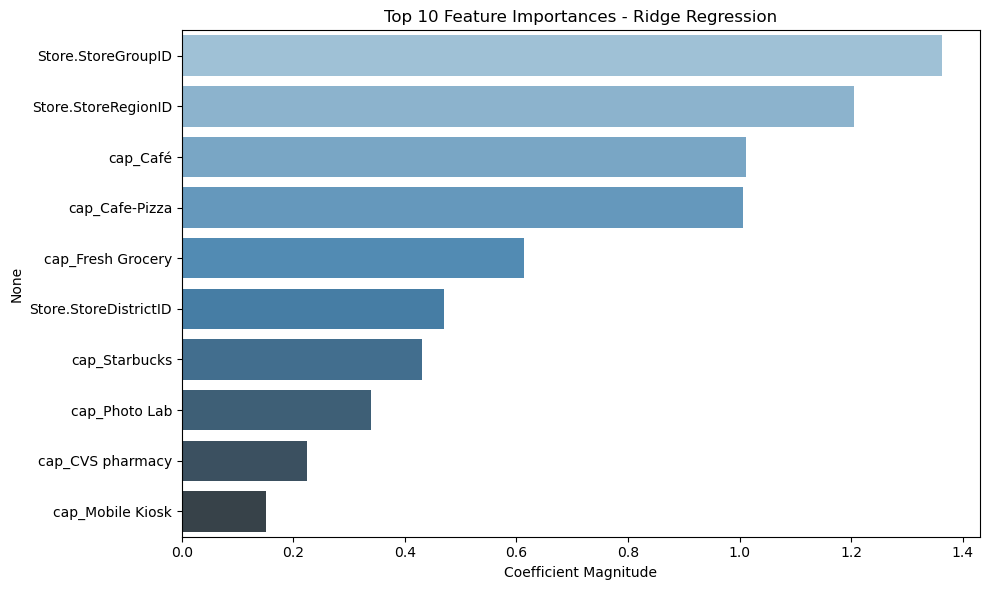


🔹 Lasso Regression Metrics:
R2 Score: 0.119
MAE: 2.28
RMSE: 3.17


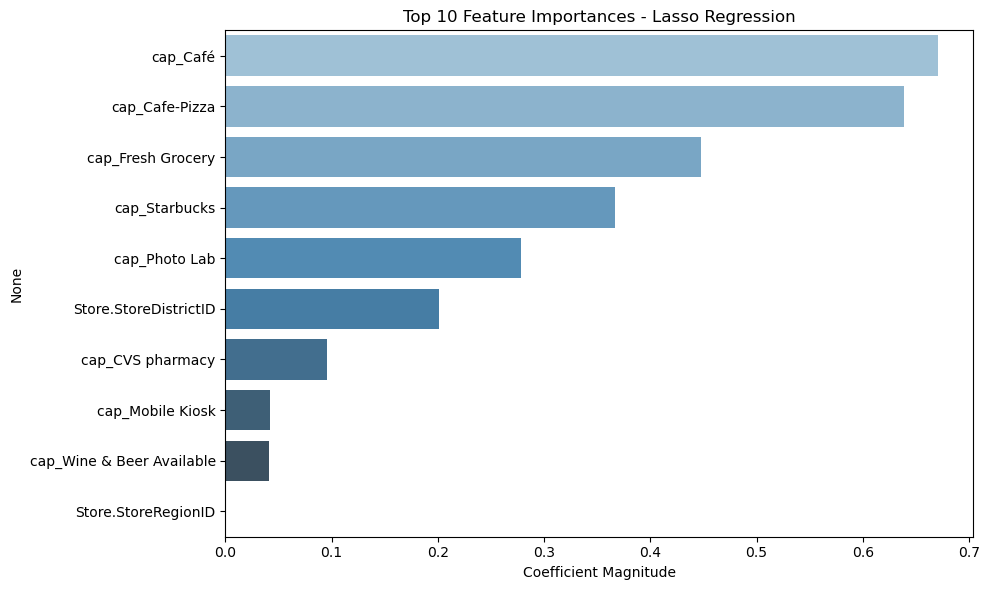

In [47]:

# Step 8: Predict and evaluate
for model, name in [(ridge, "Ridge"), (lasso, "Lasso")]:
    y_pred = model.predict(X_test_scaled)
    print(f"\n🔹 {name} Regression Metrics:")
    print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

    # Coefficients plot
    coef = pd.Series(model.coef_, index=X.columns)
    top_coef = coef.abs().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_coef.values, y=top_coef.index, palette='Blues_d')
    plt.title(f"Top 10 Feature Importances - {name} Regression")
    plt.xlabel("Coefficient Magnitude")
    plt.tight_layout()
    plt.show()


### Model 2: RandomForestRegressor


🔹 Random Forest Regressor Metrics:
R2 Score: 0.167
MAE: 2.06
RMSE: 3.09


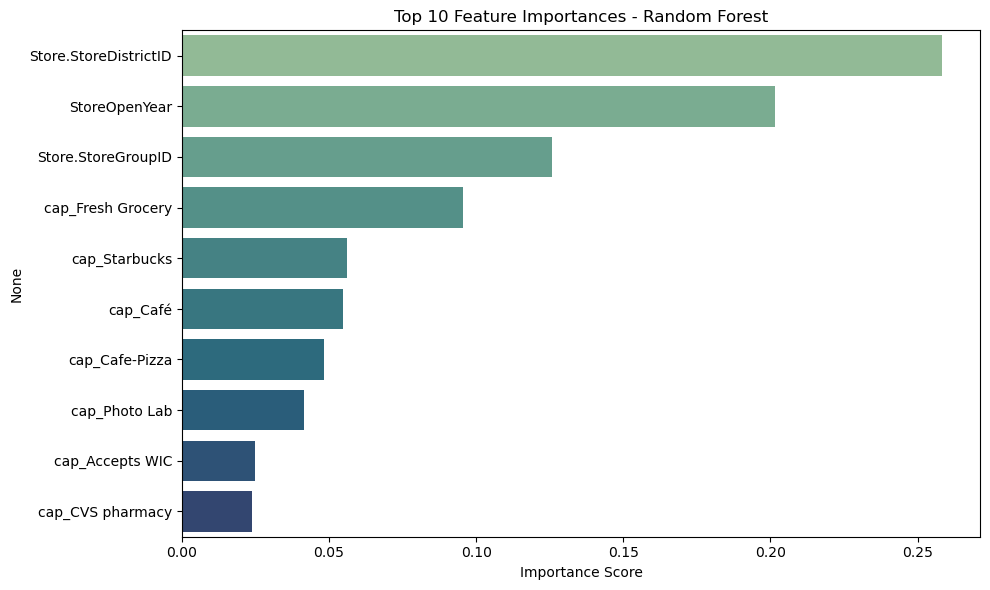

In [26]:
# Step 1: Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Use same features from earlier Ridge/Lasso model
X = pd.get_dummies(df[feature_cols], drop_first=True)
y = df['YearsSinceRemodel']

# Step 3: Split and (optional) scale
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 4: Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred = rf.predict(X_test)

print("\n🔹 Random Forest Regressor Metrics:")
print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Step 6: Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_importances = importances.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances.values, y=top_importances.index, palette='crest')
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


### Model 3: KMeans Clustering

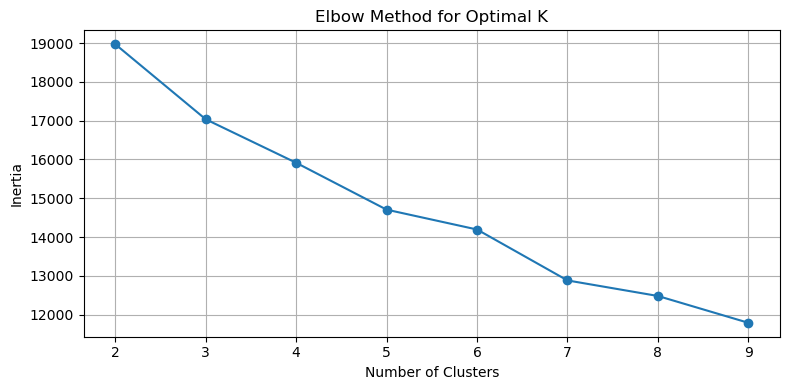

In [27]:
# Step 1: Imports
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load cleaned data
df = pd.read_csv("cleaned_target.csv").copy()

# Step 3: Parse capabilities
def extract_capabilities(row):
    try:
        return ast.literal_eval(row) if row != 'Unknown' else []
    except:
        return []

df['ParsedCapabilities'] = df['AllCapability'].apply(extract_capabilities)

# Top N capabilities as binary features
top_capabilities = pd.Series([cap for caps in df['ParsedCapabilities'] for cap in caps]).value_counts().head(10).index.tolist()
for cap in top_capabilities:
    df[f'cap_{cap}'] = df['ParsedCapabilities'].apply(lambda x: int(cap in x))

# Step 4: Select features for clustering
features = [
    'Is24Hours.MF', 'Is24Hours.Sat', 'YearsSinceRemodel', 'StoreOpenYear'
] + [f'cap_{cap}' for cap in top_capabilities]

X = df[features].fillna(0)

# Step 5: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Find optimal number of clusters using Elbow Method
inertia = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()


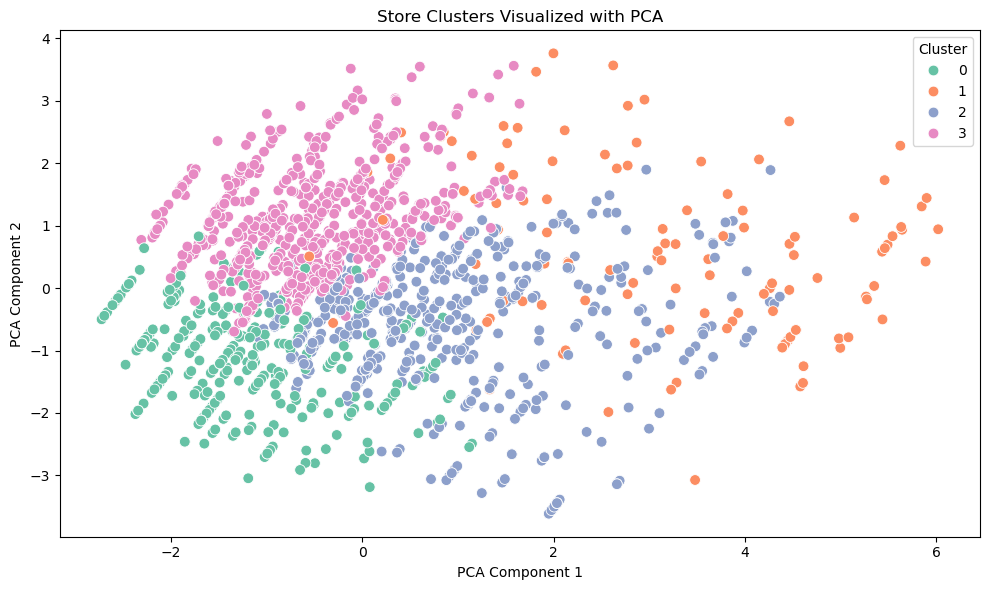

In [28]:
# Step 7: Fit KMeans with selected K
optimal_k = 4  # you can change this based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 8: Reduce to 2D with PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Step 9: Plot Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title("Store Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [29]:
# Compare averages of features across clusters
cluster_profiles = df.groupby('Cluster')[features].mean().round(2)
print(cluster_profiles)


         Is24Hours.MF  Is24Hours.Sat  YearsSinceRemodel  StoreOpenYear  \
Cluster                                                                  
0                 0.0            0.0               9.21        2007.86   
1                 0.0            0.0              13.14        1995.05   
2                 0.0            0.0              13.74        1999.44   
3                 0.0            0.0              13.91        1999.01   

         cap_CVS pharmacy  cap_Mobile Kiosk  cap_Fresh Grocery  cap_Starbucks  \
Cluster                                                                         
0                     1.0              0.96               0.96           0.96   
1                     0.0              0.56               0.52           0.52   
2                     1.0              0.72               0.69           0.75   
3                     1.0              0.97               0.99           0.81   

         cap_Cafe-Pizza  cap_Accepts WIC  cap_Photo Lab  \
Cluster  

### Model 4: NLP/Text Models

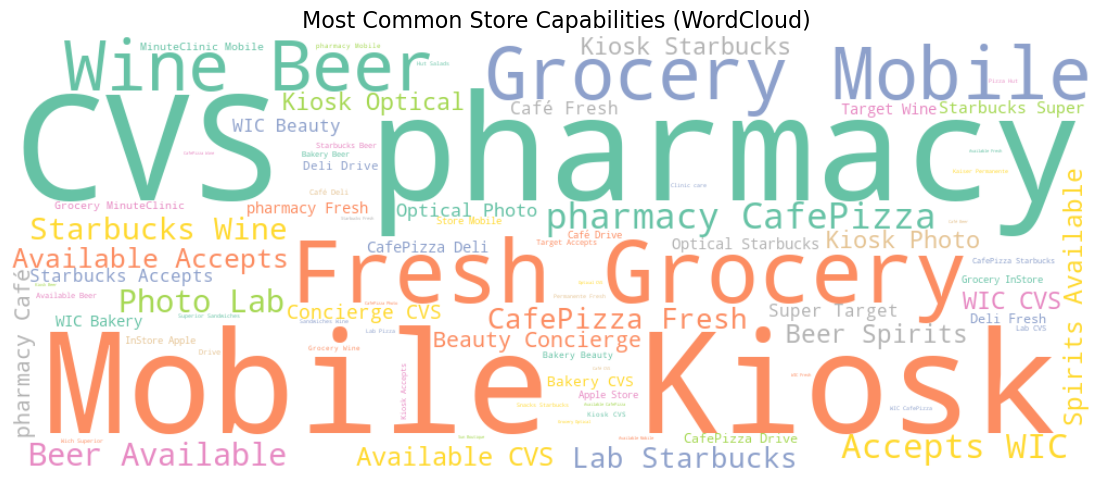

,accepts,amico,and,apple,available,bakery,beauty,beer,boutique,by,...,store,sun,super,superior,target,up,which,wic,wich,wine
0,0.0,0.0,0.0,0.0,0.302439,0.0,0.0,0.302610,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.338463
1,0.0,0.0,0.0,0.0,0.312689,0.0,0.0,0.312865,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349933
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.246212,0.0,0.0,0.246351,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275538
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [56]:
# Step 1: Imports
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load dataset and clean capability text
df = pd.read_csv("cleaned_target.csv").copy()

def clean_capability_text(row):
    try:
        items = ast.literal_eval(row) if row != 'Unknown' else []
        return ' '.join([cap.replace('-', '').replace(',', '') for cap in items])
    except:
        return ''

df['CapabilityText'] = df['AllCapability'].apply(clean_capability_text)

# Step 3: Generate WordCloud
cap_text = ' '.join(df['CapabilityText'].dropna())

wordcloud = WordCloud(width=1000, height=400, background_color='white', colormap='Set2').generate(cap_text)

plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(' Most Common Store Capabilities (WordCloud)', fontsize=16)
plt.show()

# Step 4: Create TF-IDF Matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['CapabilityText'])

# Optional: View TF-IDF feature names
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()


In [58]:
# Step 1: Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Step 2: Use the cleaned capability text
docs = df['CapabilityText'].fillna('')

# Step 3: Convert to Count Vector (for LDA)
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(docs)

# Step 4: Fit LDA Model
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # You can try 3–6 topics
lda.fit(count_data)

# Step 5: Show Top Keywords in Each Topic
def display_topics(model, feature_names, num_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n🔹 Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

display_topics(lda, count_vectorizer.get_feature_names_out())



🔹 Topic 1:
optical, kiosk, mobile, fresh, grocery

🔹 Topic 2:
drive, up, beer, available, wine

🔹 Topic 3:
cvs, pharmacy, mobile, kiosk, grocery


In [60]:
# Get topic probabilities per store
topic_matrix = lda.transform(count_data)

# Assign the topic with the highest probability to each store
df['DominantTopic'] = topic_matrix.argmax(axis=1)

# Optional: Show a few examples
df[['CapabilityText', 'DominantTopic']].head()


,CapabilityText,DominantTopic
0,CVS pharmacy Café Mobile Kiosk Starbucks Wine ...,2
1,CVS pharmacy CafePizza Fresh Grocery Mobile Ki...,2
2,,0
3,CVS pharmacy Café Fresh Grocery Mobile Kiosk P...,2
4,CVS pharmacy Café Mobile Kiosk Photo Lab,2


In [64]:
topic_matrix = lda.transform(count_data)
df['DominantTopic'] = topic_matrix.argmax(axis=1)


In [66]:
topic_labels = {
    0: "Healthcare Services",
    1: "Retail Convenience",
    2: "Photo & Media Services"
}

# If you used n_components=3 in LDA
df['TopicLabel'] = df['DominantTopic'].map(topic_labels)


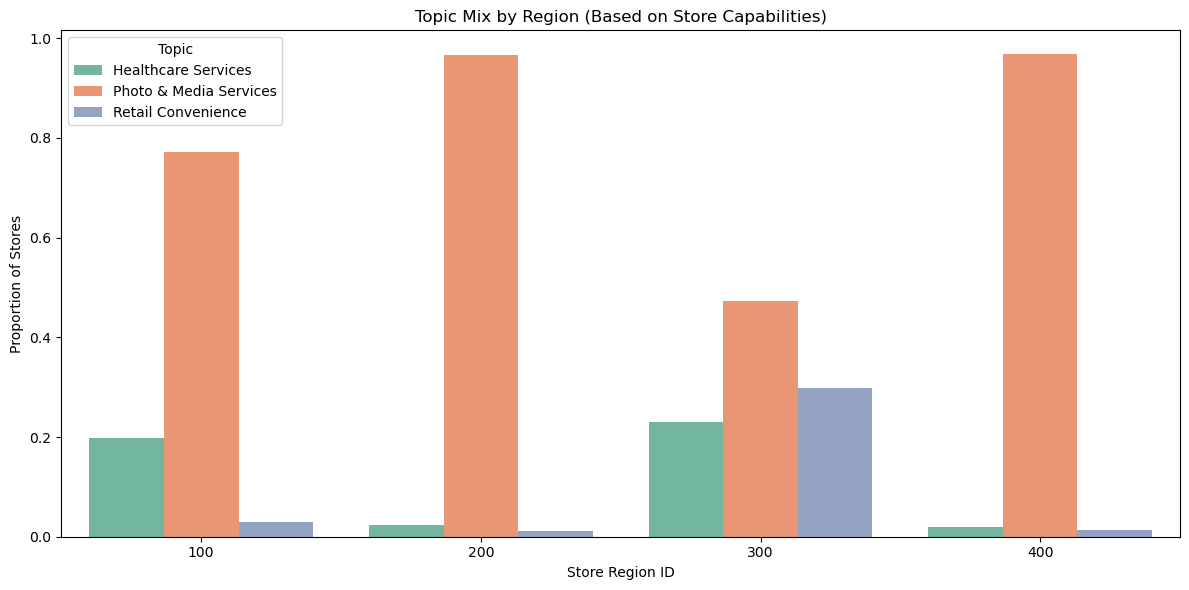

In [72]:
# Count of dominant topics by region
topic_counts = df.groupby(['Store.StoreRegionID', 'TopicLabel']).size().reset_index(name='Count')

# Normalize to get proportions
total_by_region = topic_counts.groupby('Store.StoreRegionID')['Count'].transform('sum')
topic_counts['Proportion'] = topic_counts['Count'] / total_by_region

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=topic_counts,
    x='Store.StoreRegionID',
    y='Proportion',
    hue='TopicLabel',
    palette='Set2'
)
plt.title("Topic Mix by Region (Based on Store Capabilities)")
plt.xlabel("Store Region ID")
plt.ylabel("Proportion of Stores")
plt.legend(title="Topic")
plt.tight_layout()
plt.show()


In [77]:
print(df.iloc[0]['CapabilityText'].split())


['CVS', 'pharmacy', 'Café', 'Mobile', 'Kiosk', 'Starbucks', 'Wine', '&', 'Beer', 'Available']


In [79]:
similar_indices = similarity_matrix[0].argsort()[::-1][1:6]
for idx in similar_indices:
    print(f"Store {idx} services: {df.iloc[idx]['CapabilityText'].split()}")


Store 1496 services: ['CVS', 'pharmacy', 'Café', 'Mobile', 'Kiosk', 'Starbucks', 'Wine', '&', 'Beer', 'Available']
Store 1503 services: ['CVS', 'pharmacy', 'Café', 'Mobile', 'Kiosk', 'Starbucks', 'Wine', '&', 'Beer', 'Available']
Store 1085 services: ['CVS', 'pharmacy', 'Café', 'Mobile', 'Kiosk', 'Starbucks', 'Wine', '&', 'Beer', 'Available']
Store 1806 services: ['CVS', 'pharmacy', 'Café', 'Mobile', 'Kiosk', 'Starbucks', 'Wine', '&', 'Beer', 'Available']
Store 64 services: ['CVS', 'pharmacy', 'Café', 'Mobile', 'Kiosk', 'Wine', '&', 'Beer', 'Available']


### Model 5: Recommendation Systems

In [81]:
# Step 1: Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast

# Step 2: Load & clean text
df = pd.read_csv("cleaned_target.csv").copy()

def clean_capability_text(row):
    try:
        items = ast.literal_eval(row) if row != 'Unknown' else []
        return ' '.join([cap.replace('-', '').replace(',', '') for cap in items])
    except:
        return ''

df['CapabilityText'] = df['AllCapability'].apply(clean_capability_text)

# Step 3: TF-IDF transformation
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['CapabilityText'])

# Step 4: Compute cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

# Step 5: Recommendation function
def recommend_capabilities(store_index, top_n=3):
    store_services = set(df.iloc[store_index]['CapabilityText'].split())
    similar_indices = similarity_matrix[store_index].argsort()[::-1][1:top_n+1]

    recommended_services = set()
    for idx in similar_indices:
        other_services = set(df.iloc[idx]['CapabilityText'].split())
        new_services = other_services - store_services
        recommended_services.update(new_services)

    return list(recommended_services)

# Example: Recommend for first store
recommendations = recommend_capabilities(store_index=0, top_n=10)

print(f"🛍️ Recommended services for store 0:\n{recommendations}")


🛍️ Recommended services for store 0:
['Fresh', 'Grocery']


In [87]:
import pandas as pd
import ast
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Step 1: Load and clean
df = pd.read_csv("cleaned_target.csv").copy()

def clean_capability_text(row):
    try:
        items = ast.literal_eval(row) if row != 'Unknown' else []
        return ' '.join([cap.replace('-', '').replace(',', '') for cap in items])
    except:
        return ''

df['CapabilityText'] = df['AllCapability'].apply(clean_capability_text)

# Step 2: TF-IDF + Clustering (if not already done)
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['CapabilityText'])

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(tfidf_matrix)

# Step 3: Generate recommendations for each store
store_recs = []
for idx in range(len(df)):
    store_cluster = df.iloc[idx]['Cluster']
    cluster_mates = df[df['Cluster'] == store_cluster]
    
    cluster_services = Counter(" ".join(cluster_mates['CapabilityText']).split())
    store_services = set(df.iloc[idx]['CapabilityText'].split())
    
    recommended = [s for s, _ in cluster_services.most_common(10) if s not in store_services]
    store_recs.append(', '.join(recommended))

df['RecommendedServices'] = store_recs

# Step 4: Export file for BigQuery + Tableau
df[['ID', 'StoreOpenYear', 'YearsSinceRemodel', 'Cluster', 'RecommendedServices']].to_csv("store_recommendations.csv", index=False)
print("✅ store_recommendations.csv exported successfully.")


✅ store_recommendations.csv exported successfully.


In [89]:
# Re-export with clean formatting
df[['ID', 'StoreOpenYear', 'YearsSinceRemodel', 'Cluster', 'RecommendedServices']].to_csv(
    "store_recommendations_clean.csv",
    index=False,
    encoding='utf-8',
    quoting=1  # Use minimal quoting
)


In [91]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv("cleaned_target.csv")

# Rename all columns: replace '.' with '_'
df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)

# Optional: preview new column names
print(df.columns.tolist())

# Export with clean column names
df.to_csv("cleaned_target_bigquery_ready.csv", index=False, encoding='utf-8')
print("✅ File saved as 'cleaned_target_bigquery_ready.csv'")


['X_locale', 'Address_AddressLine1', 'Address_City', 'Address_CountryName', 'Address_County', 'Address_FormattedAddress', 'Address_IntersectionDescription', 'Address_Latitude', 'Address_Longitude', 'Address_PostalCode', 'Address_Subdivision', 'AlternateIdentifier_ID', 'ID', 'IsDaylightSavingsTimeRecognized', 'LocationMilestones_LastRemodelDate', 'LocationMilestones_OpenDate', 'Market', 'Name', 'OperatingHours__timeFormat', 'Store_StoreDistrictID', 'Store_StoreGroupID', 'Store_StoreRegionID', 'SubTypeDescription', 'TimeZone_TimeZoneCode', 'TimeZone_TimeZoneDescription', 'TimeZone_TimeZoneOffset_OffsetCode', 'TimeZone_TimeZoneOffset_OffsetHours', 'TypeCode', 'PhoneNumber', 'FaxNumber', 'BeginTime_MF', 'Is24Hours_MF', 'IsOpen_MF', 'Summary_MF', 'ThruTime_MF', 'BeginTime_Sat', 'Is24Hours_Sat', 'IsOpen_Sat', 'Summary_Sat', 'ThruTime_Sat', 'BeginTime_Sun', 'Is24Hours_Sun', 'IsOpen_Sun', 'Summary_Sun', 'ThruTime_Sun', 'AllCapability', 'StoreOpenYear', 'YearsSinceRemodel']
✅ File saved as 'cle